In [2]:
'''
Algoritmo A*
1) Cree un grafo de búsqueda G y una lista ABIERTA y ponga a s en cada uno de ellos.
2) Cree una lista vacía CERRADA.
3) Si ABIERTA está vacía retorne con Falla.
4) Remueva el 1er nodo = n de ABIERTA y colóquela en CERRADA.
5) Si n = Meta retorne con Éxito.
6) Genere los M sucesores de n que no sean sus ancestros y póngalos en G.
7) Establezca punteros a n desde sus descendientes que no estén ni en ABIERTA ni en CERRADA
    agregue los M sucesores a la lista ABIERTA y en caso que ya estuvieran redireccione los punteros
    si es un camino más corto.
8) Reordene ABIERTA.
9) Vaya al punto 3

'''
import networkx as nx
import matplotlib as plt
import random
import pickle
import os
import json
import logging
from datetime import datetime, timedelta
from utils import hierarchy_pos2

class Nodo:
    def __init__(self, datos):
        self.datos = datos
        self.ante = None
        self.post = None

class ListaDoblEnlaz:  
    def __init__(self):
        self.nodo_inicio = None

    def insertar_vacio(self, datos):
        if self.nodo_inicio is None:
            nuevo_nodo = Nodo(datos)
            self.nodo_inicio = nuevo_nodo
            return True
        else:
            return False

    def insertar_al_inicio(self, datos):
        if self.nodo_inicio is None:
            nuevo_nodo = Nodo(datos)
            self.nodo_inicio = nuevo_nodo
            return True
        nuevo_nodo = Nodo(datos)
        nuevo_nodo.post = self.nodo_inicio
        self.nodo_inicio.ante = nuevo_nodo
        self.nodo_inicio = nuevo_nodo
        return True

    def insertar_al_final(self, datos):
        if self.esta_vacia():
            self.insertar_vacio(datos)
            return True
        n = self.nodo_inicio
        while n.post is not None:
            n = n.post
        nuevo_nodo = Nodo(datos)
        n.post = nuevo_nodo
        nuevo_nodo.ante = n
        return True

    def insertar_nodo(self, datos):
        return self.insertar_nodo_FN_CREC(datos)
        #return self.insertar_nodo_FN(datos)

    def insertar_nodo_FN_CREC(self, datos):
        # esta funcion inserta el nodo en la lista ordenado por Fn ascendente y cant de recorridos descendente
        if self.esta_vacia():
            self.insertar_vacio(datos)
            return True
        n = self.nodo_inicio
        while n is not None:
            if (n.datos['Fn'] >= datos['Fn']):
                if (len(n.datos['recorrido']) <= len(datos['recorrido'])):
                    nuevo_nodo = Nodo(datos)
                    nuevo_nodo.ante = n.ante
                    nuevo_nodo.post = n
                    if (n is self.nodo_inicio):
                        self.nodo_inicio = nuevo_nodo
                    else:
                        n.ante.post = nuevo_nodo
                    n.ante = nuevo_nodo
                    return True
            n = n.post
        n = self.nodo_inicio
        while n is not None:
            if (n.datos['Fn'] >= datos['Fn']):
                nuevo_nodo = Nodo(datos)
                nuevo_nodo.ante = n.ante
                nuevo_nodo.post = n
                if (n is self.nodo_inicio):
                    self.nodo_inicio = nuevo_nodo
                else:
                    n.ante.post = nuevo_nodo
                n.ante = nuevo_nodo
                return True
            n = n.post
        self.insertar_al_final(datos)
        return True

    def insertar_nodo_FN(self, datos):
        # esta funcion inserta el nodo en la lista ordenado por Fn ascendente
        if self.esta_vacia():
            self.insertar_vacio(datos)
            return True
        n = self.nodo_inicio
        while n is not None:
            if (n.datos['Fn'] > datos['Fn']):
                nuevo_nodo = Nodo(datos)
                nuevo_nodo.ante = n.ante
                nuevo_nodo.post = n
                if (n.ante is not None):
                    n.ante.post = nuevo_nodo
                n.ante = nuevo_nodo
                return True
            n = n.post
        self.insertar_al_final(datos)

    def obtener_primero(self):
        return self.nodo_inicio.datos

    def esta_vacia(self):
        if self.nodo_inicio is None:
            return True
        else:
            return False

    def borrar_primero(self):
        if self.nodo_inicio is None:
            return False
        if self.nodo_inicio.post is None:
            self.nodo_inicio = None
            return True
        n = self.nodo_inicio.post
        n.ante = None
        self.nodo_inicio = n
        return True

    def obtener_primero_y_borrar(self):
        primero = self.obtener_primero()
        estado = self.borrar_primero()
        return estado, primero

    def obtener_toda_la_lista(self, drop=False):
        vector = []
        if (drop == True):
            for a in range(self.obtener_cantidad()):
                vector.append([self.obtener_primero_y_borrar()])
        else:
            n = self.nodo_inicio
            while n is not None:
                vector.append(n.datos)
                n = n.post
        return vector

    def obtener_cantidad(self):
        a = 1
        if self.esta_vacia():
            return a
        n = self.nodo_inicio
        while n.post is not None:
            n = n.post
            a += 1
        return a

    def agregar_sucesores(self, grafoG, mat_costCiu, id_autoinc, nodo_n, sucesores):
        estado_total = True
        # n es el nodo_n con uId == nodo_nUID
        for a in sucesores:
            # se calculan los Gn, Hn y Fn del nodo_n

            # se agrega el recorrido a la ciudad sucesora
            recorrido = [a for a in nodo_n['recorrido']]
            recorrido.append(a)

            # se copia el vector de costos del padre al hijo
            costos = [a for a in nodo_n['costos']]

            # se toma el costo de ir desde el padre al sucesor
            costo = mat_costCiu[nodo_n['recorrido'][-1:][0]-1][a-1]
            #print(a, nodo_n['uId'])
            #print(costo)
            #print(costos)

            # se quita dicho costo del vector de costos restantes ya ordenado
            costos.remove(costo)

            # se cuenta la cantidad de recorridos faltantes
            cant_faltantes = len(mat_costCiu[0])-len(nodo_n['recorrido'])

            if (cant_faltantes == 1):
                Hn = mat_costCiu[0][a-1]
            else:
                Hn = 0
                for b in [a for a in costos[:cant_faltantes]]:
                    Hn += b
            
            # workaround para incluir el costo si es el ultimo recorrido hacia el origen
            if (len(costos) == 1):
                costos.append(mat_costCiu[0][a-1])
                costos.sort(reverse=False)

            datos = dict(
                uId = (id_autoinc, "ciudad{}".format(a)),
                recorrido = recorrido,
                costos = costos, 
                Gn = nodo_n['Gn'] + costo,
                Hn = Hn,
                Fn = nodo_n['Gn'] + costo + Hn
            )

            # se inserta al sucesor en la lista Abierta de manera ordenada
            estado = self.insertar_nodo(datos)
            ''' #PARA DEBUGGING
            print("=======================")
            for a in self.obtener_toda_la_lista(drop=False):
                print(a)
            print("=======================")
            '''
            if (estado == False):
                estado_total = False
                print("error")
                break
            #print("estado insercion datos:{}, {}".format(datos,estado))
            
            # se agrega al grafo el sucesor
            edges = []
            edges.append([nodo_n['uId'],datos['uId']])
            id_autoinc += 1
            grafoG.add_edges_from(edges) #DESCOMENTAR LUEGO
        
        return estado_total, id_autoinc, grafoG

class AEstrella:
    def __init__(self, sem_control=True):
        # semaforo para indicar si la ejecución utilizará o no puntos de control
        self.sem_control = sem_control

        # Variables necesarias para el algoritmo 
        # nada
    def _leerArchConf(self, archivo):
        arch = open(archivo)
        cantCiu = int(arch.readline().split(';')[0])
        vec_costCiu = [int(a) for a in arch.readline().split(';') if a != '\n']
        vecmat_costCiu = []

        vec_costCiu_aux = [a for a in vec_costCiu]
        for a in range(cantCiu):
            
            #TODO: optimizar -> c no se usa y se puede hacer mejor un append con ceros
            # Se inicializa en ceros el vector de costos de las ciudades que se utilizara para llenar la matriz de costos
            for c in range(a+1):
                vecmat_costCiu.append(0)
            
            # se llena el triangulo superior de la matriz
            for b in range(cantCiu-a-1):
                vecmat_costCiu.append(vec_costCiu_aux[0])
                vec_costCiu_aux = vec_costCiu_aux[1:]

        # se traspone el triangulo superior y se almacenan sus valores
        for a in range(cantCiu):
            for b in range(cantCiu):
                if b < a:
                    # si la columna es menor a la fila, se copia el valor de su opuesto
                    vecmat_costCiu[cantCiu*a+b] = vecmat_costCiu[cantCiu*b+a]

        # se termina de componer la matriz
        mat_costCiu = []
        for a in range(cantCiu):
            mat_costCiu.append(vecmat_costCiu[:cantCiu])
            vecmat_costCiu = vecmat_costCiu[cantCiu:]

        # se compone el objeto (dict) para agilizar el calculo de costos (costo de N a M). Es una mejora hallada desde el analisis del profile del commit fcdd01
        obj_costCiu = dict()
        for a in range(1,cantCiu+1):
            indice_1 = "ciudad{}".format(a)
            obj_costCiu[indice_1] = dict()
            for b in range(1,cantCiu+1):
                if (a is not b):
                    indice_2 = "ciudad{}".format(b)
                    obj_costCiu[indice_1][indice_2] = mat_costCiu[a-1][b-1]

        return cantCiu, vec_costCiu, mat_costCiu, obj_costCiu

    def _imprimir_y_logguear_variables(self, listAbierta):

        mensaje = "-------------------------"
        print(mensaje)
        self.logger.info(mensaje)

        mensaje = "iteracion: {}".format(self.iteracion)
        print(mensaje)
        self.logger.info(mensaje)
        
        mensaje = "nodo_s: {}".format(self.nodo_s)
        print(mensaje)
        self.logger.info(mensaje)
        mensaje = "nodo_n: {}".format(self.nodo_n)
        print(mensaje)
        self.logger.info(mensaje)

        mensaje = "sucesores: {}".format(self.sucesores)
        print(mensaje)
        self.logger.info(mensaje)
        mensaje = "ciudades: {}".format(self.ciudades)
        print(mensaje)
        self.logger.info(mensaje)
        mensaje = "cantCiu: {}".format(self.cantCiu)
        print(mensaje)
        self.logger.info(mensaje)

        mensaje = "vec_costCiu: {}".format(self.vec_costCiu)
        print(mensaje)
        self.logger.info(mensaje)
        mensaje = "mat_costCiu: {}".format(self.mat_costCiu)
        print(mensaje)
        self.logger.info(mensaje)
        mensaje = "obj_costCiu: {}".format(self.obj_costCiu)
        print(mensaje)
        self.logger.info(mensaje)

        mensaje = "id_autoinc: {}".format(self.id_autoinc)
        print(mensaje)
        self.logger.info(mensaje)

        mensaje = "listAbierta.primero: {}".format(self.listAbierta.obtener_primero())
        print(mensaje)
        self.logger.info(mensaje)
        mensaje = "listAbierta.cantidad: {}".format(self.listAbierta.obtener_cantidad())
        print(mensaje)
        self.logger.info(mensaje)
        
        mensaje = "-------------------------"
        print(mensaje)
        self.logger.info(mensaje)

        return

    def _imprimir_resultados_finales(self):
        mensaje = "La cantidad de nodos abiertos fue de: {}".format(self.iteracion)
        print(mensaje)
        self.logger.info(mensaje)

        mensaje = "El óptimo recorrido es: {}".format(0)
        print(mensaje)
        self.logger.info(mensaje)

        mensaje = "O dicho de otro modo el recorrido es: {}".format(self.nodo_n['recorrido'])
        print(mensaje)
        self.logger.info(mensaje)

        mensaje = "El costo total del óptimo recorrido es de: {}".format(self.optimo_costo)
        print(mensaje)
        self.logger.info(mensaje)

        mensaje = "El tiempo de procesamiento total fue de: {} segundos".format(self.duracion)
        print(mensaje)
        self.logger.info(mensaje)

        print("Fin del proceso")
        self.logger.info("Fin del proceso")
    
        return


    def _calcular_sucesores(self):
        sucesores = []
        # se verifica que sea el ultimo nodo a agregar
        if (len(self.nodo_n['recorrido']) == self.cantCiu):
            sucesores = [1]
        else:
        # sino se calculan los sucesores de nodo_n en base a su recorrido actual 
            for a in self.ciudades:
                if (a not in self.nodo_n['recorrido']):
                    sucesores.append(a)
        return sucesores

    def Procesar(self, archivo):
        '''
        1er test, sacado de TSP/TSP_IN_01.txt
        cantCiu = 5
        vec_costCiu = [5,15,17,7,6,19,20,7,21,5]
        mat_costCiu = [
            [ 0, 5,15,17, 7],
            [ 5, 0, 6,19,20],
            [15, 6, 0, 7,21],
            [17,19, 7, 0, 5],
            [ 7,20,21, 5, 0]
        ]
        '''

        # 2do test: sacado del archivo de configuracion utilizando la funcion para tal fin
        self.archivo = archivo
        self.arch_control = "{}.control".format(archivo)
        archivo_final = "{}.resultados".format(archivo)

        self.logger = logging.getLogger('AEstrella')
        hdlr = logging.FileHandler('log/{}_{}.log'.format(self.archivo.split('/')[1].split('.')[0], datetime.now().strftime("%Y%m%d_%H%M%S")))
        formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
        hdlr.setFormatter(formatter)
        self.logger.addHandler(hdlr) 
        self.logger.setLevel(logging.INFO)
        
        self.logger.info("Inicio del proceso")

        # Se chequea si existe un archivo de control
        if (self.sem_control == True and (os.path.isfile(self.arch_control) or os.path.isfile("{}_viejo".format(self.arch_control)))):

            if (not(os.path.isfile(self.arch_control)) and os.path.isfile("{}_viejo".format(self.arch_control))):
                self.logger.info("Existe un archivo de control viejo para la ejecucion elegida, parece que el proceso se corto de manera inesperada")
                print("Existe un archivo de control viejo para la ejecucion elegida, parece que el proceso se corto de manera inesperada")
                # Se renombra el archivo viejo de control para tomarlo como ultimo control
                os.rename("{}_viejo".format(self.arch_control), self.arch_control)

            if (os.path.isfile(self.arch_control)):
                self.logger.info("Existe un archivo de control para la ejecucion elegida")
                print("Existe un archivo de control para la ejecucion elegida")
                with open(self.arch_control, 'rb') as f:
                    self = pickle.load(f)
                    f.close()

            # Se le miente al algoritmo para que piense que es la primera vez que ejecuta al modificar el tiempo antes y despues de la ejecucion
            # esto sirve para mantener coherencia con los tiempos de ejecución al cargar un archivo de control
            X=(self.despues - self.antes).total_seconds()
            self.antes = datetime.now() - timedelta(seconds=X)
            self.despues = datetime.now() #solucion al caso en el que ya haya terminado y levantara el archivo de control

        elif ((self.sem_control == True or not(os.path.isfile(self.arch_control) or os.path.isfile("{}_viejo".format(self.arch_control)))) or self.sem_control == False):

            print("No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo")

            self.cantCiu, self.vec_costCiu, self.mat_costCiu, self.obj_costCiu = self._leerArchConf(self.archivo)

            self.ciudades = [a for a in range(1,self.cantCiu+1)]
            self.iteracion = 1

            # se calcula la fecha y hora antes de procesar
            self.antes = datetime.now()


            ## Modelo el algoritmo A* de forma tal que cada nodo del grafo es una ciudad
            ## la ciudad de inicio y de fin será la 1 pero terminará habiendo recorrido todas las ciudades
            ## nota: el grafo no admite nodos iguales para lo cual diseño cada nodo (ciudad) de forma unívoca con un ID y el nombre de la ciudad (ej: 'ciudad1')
            ## El algoritmo procesa el archivo y deja los resultados en <nombre_archivo>.resultados con el siguiente formato:
            '''
            La cantidad de nodos abiertos fue de: 18
            El optimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (11, 'ciudad3'), (27, 'ciudad4'), (41, 'ciudad5'), (53, 'ciudad6'), (63, 'ciudad7'), (71, 'ciudad8'), (77, 'ciudad9'), (81, 'ciudad10')]
            O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad3', 'ciudad4', 'ciudad5', 'ciudad6', 'ciudad7', 'ciudad8', 'ciudad9', 'ciudad10']
            El costo total del optimo recorrido es de: 10
            El tiempo de procesamiento total fue de: 0.465711 segundos
            '''

            ## y asi es como lo proponia la catedra:
            '''
            strCamino es un string con el camino encontrado, de la forma "1;2;3;4;5;1;"
            CT es el costo total del camino encontrado.
            NA es la cantidad de nodos abiertos durante el proceso.
            strTiempoEj es un string con el tiempo de ejecución.
            '''

            '''
            1) Se crea un grafo de busqueda G y una lista ABIERTA y se coloca a s en cada uno de ellos.
            '''
            # creacion del grafo de busqueda G
            self.grafoG = nx.Graph()

            # se instancia la lista ABIERTA y se crea el primer nodo
            self.listAbierta = ListaDoblEnlaz()
            self.costos_ordenados = [a for a in self.vec_costCiu]
            self.costos_ordenados.sort(reverse = False)
            self.nodo_s = dict(uId = (1,'ciudad1'),
                    recorrido = [1],
                    costos = self.costos_ordenados,
                    Fn = 0,
                    Gn = 0,
                    Hn = 0)
            
            #se copian el nodo inicio a listAbierta
            self.listAbierta.insertar_vacio(self.nodo_s)
            self.id_autoinc = 2 #id_autoinc lo uso como identificador de nodo (el proximo a utilizar debera ser el valor 2)
            
            self.nodo_n = self.nodo_s #se inicializa el nodo_n para asegurar consistencia de codigo, solo utilizado en el chequeo de la meta en la primera iteracion

            self.EXIT = False #variable para exit forzado con fines de debugging

            '''
            2) Se crea una lista vacía CERRADA. 
            '''
            # se obvia este paso ya que solo se laburara con la lista ABIERTA


        # Ya sea por una ejecución nueva o por una ejecución con archivo de control, se continua con el algoritmo....

        buffer_salida = ""
        while(self.listAbierta.esta_vacia() is False and self.EXIT is False):
           
            '''
            3) Si ABIERTA está vacía retorne con Falla.
            '''
            if (self.listAbierta.esta_vacia() is True):
                print("lista ABIERTA vacia")
                break

            '''
            5) Si n = Meta se retorna con Éxito.
            '''
            # la condicion de exito se evalua primero que el paso 4 debido a la implementacion del algoritmo elegida
            # la condicion se cumple si se llega nuevamente al origen y si la cantidad de ciudades recorridas fuese mayor a la cantidad de ciudades (esto es así porque el nodo inicio cuenta como 1, entonces deberá cumplirse que la cantidad sea cantCiu+1)

            if (self.nodo_n['uId'][1] == 'ciudad1' and (len(self.nodo_n['recorrido']) > self.cantCiu)):
                self.cond_exito = True
                print("EXITO")
                break

            # habilitar si se quiere debuggear
            # TODO: estaria bueno se pueda habilitar por iteración y no por nodo abierto ya que así no depende de las ciudades
            if self.nodo_n['uId']==(4,'ciudad4'):
                #self.EXIT = True
                pass

            '''
            4) Se remueve el 1er nodo = n de ABIERTA y se lo coloca en CERRADA.
            '''
            # Se remueve el 1er nodo = n
            # y se lo coloca en CERRADA 
            # nota: en nuestro caso n es n_abierto, n_abierto siempre será 0 porque es el primer elemento (0) de la lista
            self.nodo_n = self.listAbierta.obtener_primero()
            if (self.listAbierta.borrar_primero() == False):
                print("Error al borrar el primer elemento de la lista")
                self.EXIT = True
                break

            '''
            6) Se generan los M sucesores de n que no sean sus ancestros y se los pone en G.
            '''
            # se genera el ultimo nodo que sera el origen

            self.sucesores = self._calcular_sucesores()

            '''
            7) Establezca punteros a n desde sus descendientes que no estén ni en ABIERTA ni en CERRADA
                agregue los M sucesores a la lista ABIERTA y en caso que ya estuvieran redireccione los punteros
                si es un camino más corto.
            8) Reordene ABIERTA
            '''
            # En base a la lista de sucesores obtenidos se calculan sus Gn, Hn y Fn y se los agregará a la lista ABIERTA
            estado, self.id_autoinc, self.grafoG = self.listAbierta.agregar_sucesores(self.grafoG, self.mat_costCiu, self.id_autoinc, self.nodo_n, self.sucesores)

            if (estado == False):
                print("Hubo un error en la insercion de los sucesores de n")
                self._imprimir_y_logguear_variables(self.listAbierta)
                self.EXIT = True
                break

            self.despues = datetime.now()
            if (self.sem_control == True):
                cant = self.iteracion
                if ((cant == 1) or (cant <= 250 and cant % 50 == 0) or (cant > 250 and cant <= 1000 and cant % 100 == 0) or (cant > 1000 and cant <= 4000 and cant % 200 == 0) or (cant > 4000 and cant % 250 == 0)):
                    # Se guarda el estado de la clase para un posible futuro uso
                    with open("{}_temp".format(self.arch_control), 'wb') as f:
                        pickle.dump(self, f)
                        f.close()
                    hay_archivo = os.path.isfile(self.arch_control)
                    if (hay_archivo):
                        os.rename(self.arch_control, "{}_viejo".format(self.arch_control))
                    os.rename("{}_temp".format(self.arch_control), self.arch_control)
                    if (hay_archivo):
                        os.remove("{}_viejo".format(self.arch_control))
                    self.logger.info("Se guardo el archivo de control en la iteracion nro: {}".format(cant))

            ''' #PARA DEBUGGING
            self._imprimir_y_logguear_variables(self.listAbierta)
            print("=======================")
            for a in self.listAbierta.obtener_toda_la_lista(drop=False):
                print(a)
            print("=======================")
            '''

            cant = self.iteracion
            if (cant == 36 or cant == 48 or cant == 65):
                self.logger.info("=======================")
                for a in self.listAbierta.obtener_toda_la_lista(drop=False):
                    self.logger.info(a)
                self.logger.info("=======================")
            if ((cant == 100) or (cant <= 25000 and cant % 5000 == 0) or (cant > 25000 and cant <= 100000 and cant % 10000 == 0) or (cant > 100000 and cant <= 400000 and cant % 20000 == 0) or (cant > 400000 and cant % 25000 == 0)):
                self.logger.info("Se abrio el nodo: {}".format(self.nodo_n['uId']))
                self.logger.info("El proximo nodo a abrir será: {}".format(self.listAbierta.obtener_primero()['uId']))
                self.logger.info("La cantidad de nodos abiertos es de: {}".format(self.iteracion))
                self.logger.info("La cantidad de nodos a abrir es de: {}".format(self.listAbierta.obtener_cantidad()))
                #self.logger.info(buffer_salida)
                #buffer_salida = ""
            
            #buffer_salida += "Se abrio el nodo: {}\n".format(self.nodo_n['uId'])
            #buffer_salida += "El proximo nodo a abrir será: {}\n".format(self.listAbierta.obtener_primero()['uId'])
            #buffer_salida += "La cantidad de nodos abiertos es de: {}\n".format(self.iteracion)
            #buffer_salida += "La cantidad de nodos a abrir es de: {}\n".format(self.listAbierta.obtener_cantidad())
            

            #TODO: Imprimir por pantalla el estado cada cierta cantidad de iteraciones (pero guardar en un buffer para imprimir de a bulks)
            #Se imprime el estado actual del algoritmo
            #self.logger.info("Se abrio el nodo: {}".format(self.nodo_n['uId']))
            #self.logger.info("El proximo nodo a abrir será: {}".format(self.listAbierta.obtener_primero()['uId']))
            #self.logger.info("La cantidad de nodos abiertos es de: {}".format(self.iteracion))
            #self.logger.info("La cantidad de nodos a abrir es de: {}".format(self.listAbierta.obtener_cantidad()))

            self.iteracion += 1

        self.duracion = (self.despues - self.antes).total_seconds()

        # Se almacena el dump final en formato texto:
        #json.dumps(obj, default=lambda x: x.__dict__)
        self.optimo_costo = 0
        for a in range(0,len(self.nodo_n['recorrido'])-1):
            self.optimo_costo += self.mat_costCiu[self.nodo_n['recorrido'][a]-1][self.nodo_n['recorrido'][a+1]-1]
        with open(archivo_final, 'w') as f:
            f.write("La cantidad de nodos abiertos fue de: {}\n".format(self.iteracion))
            f.write("El óptimo recorrido es: {}\n".format(self.nodo_n['recorrido']))
            f.write("El costo total del óptimo recorrido es de: {}\n".format(self.optimo_costo))
            f.write("El tiempo de procesamiento total fue de: {} segundos\n".format(self.duracion))
            #f.write("Los nodos abiertos fueron: {}\n".format(self.listCerrada))
            f.close()
        
        self._imprimir_resultados_finales()

        # se cierra el handler del log
        self.logger.removeHandler(hdlr)

        # se dibuja el grafo siempre y cuando la cantidad de nodos a graficar sea menor a 500
        if (self.iteracion <= 500):
            pos = hierarchy_pos2(self.grafoG,(1,"ciudad1"))    
            nx.draw(self.grafoG, pos=pos, with_labels=True)
        else:
            print("No se puede graficar el grafo")

#nx.draw(grafoG, pos=nx.spring_layout(grafoG))
#pos = nx.spring_layout(grafoG)  # positions for all nodes
#nx.draw_networkx_nodes(grafoG, pos, node_size=700)
#nx.draw_networkx_labels(grafoG, pos, font_size=16, font_family="sans-serif")

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 6
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 4, 3, 2, 1]
El costo total del óptimo recorrido es de: 7
El tiempo de procesamiento total fue de: 0.0 segundos
Fin del proceso


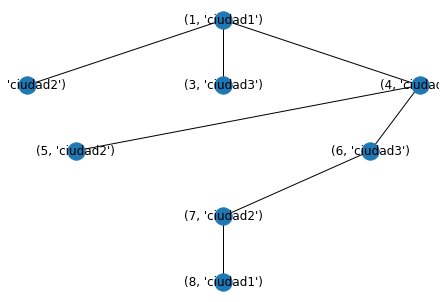

In [56]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/AGD_TSP_IN_04.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 7
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 5, 4, 3, 2, 1]
El costo total del óptimo recorrido es de: 10
El tiempo de procesamiento total fue de: 0.0 segundos
Fin del proceso


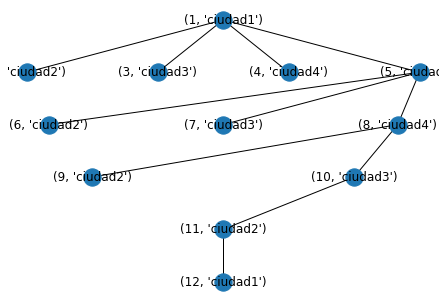

In [57]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/AGD_TSP_IN_05.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 11
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 6, 4, 2, 5, 3, 1]
El costo total del óptimo recorrido es de: 11
El tiempo de procesamiento total fue de: 0.0 segundos
Fin del proceso


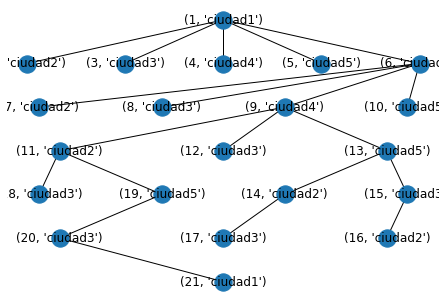

In [60]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/AGD_TSP_IN_06.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 111
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 3, 5, 7, 6, 4, 2, 1]
El costo total del óptimo recorrido es de: 25
El tiempo de procesamiento total fue de: 0.088945 segundos
Fin del proceso


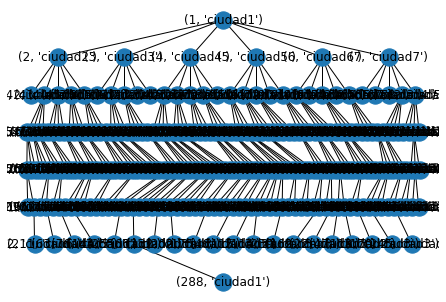

In [61]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/AGD_TSP_IN_07.txt')

In [62]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/AGD_TSP_IN_08.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 2128
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 5, 3, 7, 8, 6, 4, 2, 1]
El costo total del óptimo recorrido es de: 41
El tiempo de procesamiento total fue de: 2.388522 segundos
Fin del proceso
No se puede graficar el grafo


In [63]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/AGD_TSP_IN_09.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 7129
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 8, 4, 5, 2, 7, 6, 9, 3, 1]
El costo total del óptimo recorrido es de: 36
El tiempo de procesamiento total fue de: 47.607806 segundos
Fin del proceso
No se puede graficar el grafo


In [65]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/AGD_TSP_IN_10.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 5307
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 8, 10, 4, 5, 2, 7, 6, 9, 3, 1]
El costo total del óptimo recorrido es de: 32
El tiempo de procesamiento total fue de: 55.415713 segundos
Fin del proceso
No se puede graficar el grafo


In [66]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/AGD_TSP_IN_11.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo


In [3]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/TSP_IN_01.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 7
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 5, 4, 3, 2, 1]
El costo total del óptimo recorrido es de: 30
El tiempo de procesamiento total fue de: 0.000998 segundos
Fin del proceso


No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 9
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 7, 6, 5, 4, 2, 3, 1]
El costo total del óptimo recorrido es de: 35
El tiempo de procesamiento total fue de: 0.000999 segundos
Fin del proceso


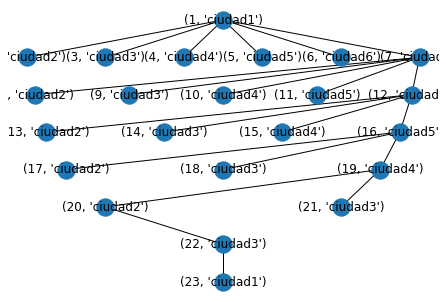

In [4]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/TSP_IN_02.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 24
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 2, 6, 3, 4, 5, 1]
El costo total del óptimo recorrido es de: 31
El tiempo de procesamiento total fue de: 0.001996 segundos
Fin del proceso


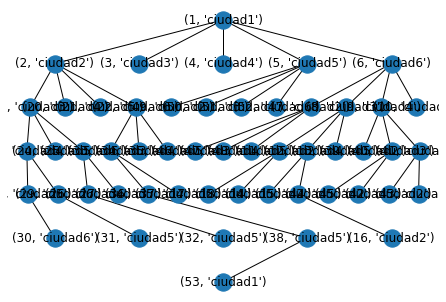

In [5]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/TSP_IN_03.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 8
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 6, 5, 4, 3, 2, 1]
El costo total del óptimo recorrido es de: 30
El tiempo de procesamiento total fue de: 0.000999 segundos
Fin del proceso


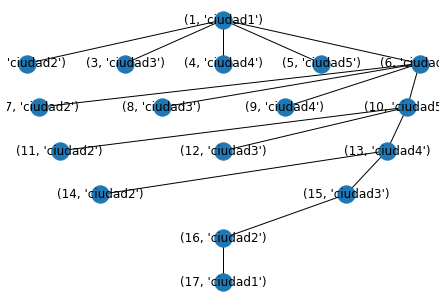

In [6]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/TSP_IN_04.txt')

In [7]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/TSP_IN_05.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 5137
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 10, 11, 5, 3, 8, 7, 2, 6, 4, 12, 9, 1]
El costo total del óptimo recorrido es de: 83
El tiempo de procesamiento total fue de: 62.941055 segundos
Fin del proceso
No se puede graficar el grafo


No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 260
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 9, 3, 8, 2, 7, 4, 5, 6, 1]
El costo total del óptimo recorrido es de: 76
El tiempo de procesamiento total fue de: 0.231855 segundos
Fin del proceso


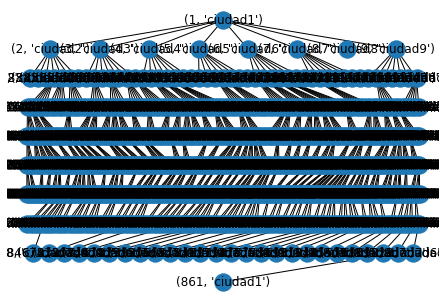

In [8]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/TSP_IN_06.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 12
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
El costo total del óptimo recorrido es de: 10
El tiempo de procesamiento total fue de: 0.002999 segundos
Fin del proceso


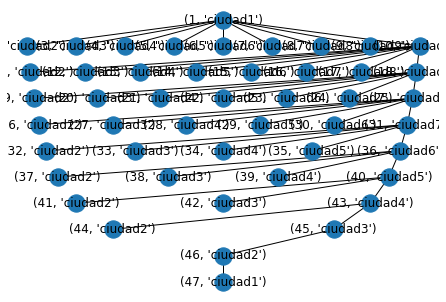

In [9]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/TSP_IN_07.txt')

In [15]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/TSP_IN_08.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo


No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 12
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
El costo total del óptimo recorrido es de: 10
El tiempo de procesamiento total fue de: 0.002003 segundos
Fin del proceso


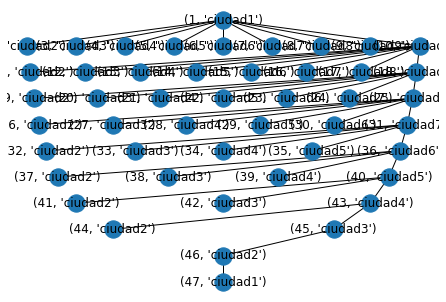

In [10]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/TSP_IN_09.txt')

In [12]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/TSP_IN_10.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 2950
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 3, 5, 7, 9, 10, 8, 6, 4, 2, 1]
El costo total del óptimo recorrido es de: 17
El tiempo de procesamiento total fue de: 18.336234 segundos
Fin del proceso
No se puede graficar el grafo


No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 17
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 13, 11, 9, 7, 5, 3, 15, 14, 12, 10, 8, 6, 4, 2, 1]
El costo total del óptimo recorrido es de: 15
El tiempo de procesamiento total fue de: 0.006995 segundos
Fin del proceso


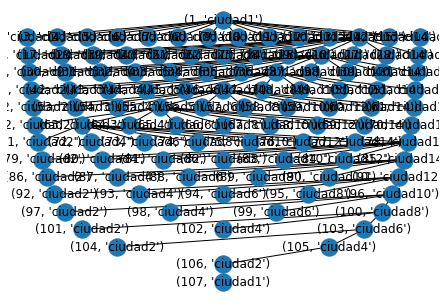

In [13]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/TSP_IN_11.txt')

No existe un archivo de control para la ejecucion elegida, se iniciara un proceso nuevo
EXITO
La cantidad de nodos abiertos fue de: 17
El óptimo recorrido es: 0
O dicho de otro modo el recorrido es: [1, 14, 9, 13, 8, 4, 12, 7, 3, 11, 6, 2, 15, 10, 5, 1]
El costo total del óptimo recorrido es de: 15
El tiempo de procesamiento total fue de: 0.004995 segundos
Fin del proceso


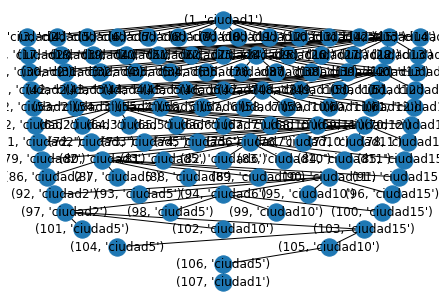

In [14]:
algoritmo = AEstrella(sem_control=False)
algoritmo.Procesar('TSP/TSP_IN_12.txt')

{'uId': (1, 'ciudad1'), 'recorrido': [1], 'costos': [1, 2, 3, 3, 3, 5, 7, 8, 8, 9], 'Gn': 0, 'Hn': 0, 'Fn': 0}
2 (1, 'ciudad1')
8
[1, 2, 3, 3, 3, 5, 7, 8, 8, 9]
estado insercion datos:{'uId': (2, 'ciudad2'), 'recorrido': [1, 2], 'costos': [1, 2, 3, 3, 3, 5, 7, 8, 9], 'Gn': 8, 'Hn': 6, 'Fn': 14}, True
3 (1, 'ciudad1')
3
[1, 2, 3, 3, 3, 5, 7, 8, 8, 9]
estado insercion datos:{'uId': (3, 'ciudad3'), 'recorrido': [1, 3], 'costos': [1, 2, 3, 3, 5, 7, 8, 8, 9], 'Gn': 3, 'Hn': 6, 'Fn': 9}, True
4 (1, 'ciudad1')
1
[1, 2, 3, 3, 3, 5, 7, 8, 8, 9]
estado insercion datos:{'uId': (4, 'ciudad4'), 'recorrido': [1, 4], 'costos': [2, 3, 3, 3, 5, 7, 8, 8, 9], 'Gn': 1, 'Hn': 8, 'Fn': 9}, True
5 (1, 'ciudad1')
2
[1, 2, 3, 3, 3, 5, 7, 8, 8, 9]
estado insercion datos:{'uId': (5, 'ciudad5'), 'recorrido': [1, 5], 'costos': [1, 3, 3, 3, 5, 7, 8, 8, 9], 'Gn': 2, 'Hn': 7, 'Fn': 9}, True
ITER 1
{'uId': (5, 'ciudad5'), 'recorrido': [1, 5], 'costos': [1, 3, 3, 3, 5, 7, 8, 8, 9], 'Gn': 2, 'Hn': 7, 'Fn': 9}
{'uId': (4

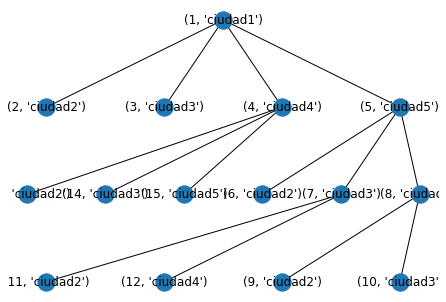

In [17]:
import networkx as nx
import matplotlib as plt
import random
import pickle
import os
import json
import logging
from datetime import datetime, timedelta
from utils import hierarchy_pos2

class Nodo:
    def __init__(self, datos):
        self.datos = datos
        self.ante = None
        self.post = None

class ListaDoblEnlaz:  
    def __init__(self):
        self.nodo_inicio = None

    def insertar_vacio(self, datos):
        if self.nodo_inicio is None:
            nuevo_nodo = Nodo(datos)
            self.nodo_inicio = nuevo_nodo
            return True
        else:
            return False

    def insertar_al_inicio(self, datos):
        if self.nodo_inicio is None:
            nuevo_nodo = Nodo(datos)
            self.nodo_inicio = nuevo_nodo
            return True
        nuevo_nodo = Nodo(datos)
        nuevo_nodo.post = self.nodo_inicio
        self.nodo_inicio.ante = nuevo_nodo
        self.nodo_inicio = nuevo_nodo
        return True

    def insertar_al_final(self, datos):
        if self.esta_vacia():
            self.insertar_vacio(datos)
            return True
        n = self.nodo_inicio
        while n.post is not None:
            n = n.post
        nuevo_nodo = Nodo(datos)
        n.post = nuevo_nodo
        nuevo_nodo.ante = n
        return True

    def insertar_nodo_prueba(self, datos):
        # esta funcion inserta el nodo en la lista ordenado por Fn ascendente y por nivel descendente
        if self.esta_vacia():
            self.insertar_vacio(datos)
            return True
        n = self.nodo_inicio
        while n is not None:
            if (n.ante is not None):
                if (n.datos['Fn'] > datos['Fn'] and n.ante.datos['Fn'] <= datos['Fn'] and len(n.datos['recorrido']) < len(datos['recorrido'])): #insertar antes de n
                    if (self.obtener_cantidad() == 1):
                        self.insertar_al_inicio(datos)
                        return True
                    # insertar antes de n pero despues del anterior
                    nuevo_nodo = Nodo(datos)
                    nuevo_nodo.ante = n.ante
                    nuevo_nodo.post = n
                    n.ante.post = nuevo_nodo
                    n.ante = nuevo_nodo
                    return True
                else:
                    if (n.datos['Fn'] > datos['Fn'] and n.ante.datos['Fn'] <= datos['Fn']):
                        # insertar luego de n pero antes del posterior
                        nuevo_nodo = Nodo(datos)
                        if (n.post is not None):
                            nuevo_nodo.post = n.post
                        else:
                            nuevo_nodo.post = None
                        nuevo_nodo.ante = n
                        if (n.post is not None):
                            n.post.ante = nuevo_nodo
                            n.post = nuevo_nodo
                        return True
                    else:
                        return False
                        print("ERRORRRRR")
            else:
                if (n.datos['Fn'] > datos['Fn']): #insertar antes de n siendo n.ante el inicio
                    self.insertar_al_inicio(datos)
                    return True
                else: #insertar luego de n siendo n.ante el inicio
                    nuevo_nodo = Nodo(datos)
                    if (n.post is not None):
                        nuevo_nodo.post = n.post
                    else:
                        nuevo_nodo.post = None
                    nuevo_nodo.ante = n
                    if (n.post is not None):
                        n.post.ante = nuevo_nodo
                        n.post = nuevo_nodo
                    return True
            if (n.post is not None):
                if (n.datos['Fn'] <= datos['Fn'] and n.post.datos['Fn'] > datos['Fn'] and len(n.datos['recorrido']) > len(datos['recorrido'])): #insertar luego de n
                    if (self.obtener_cantidad() == 1):
                        self.insertar_al_final(datos)
                        return True
                    # insertar luego de n pero antes del posterior
                    nuevo_nodo = Nodo(datos)
                    nuevo_nodo.post = n.post
                    nuevo_nodo.ante = n
                    n.post.ante = nuevo_nodo
                    n.post = nuevo_nodo
                    return True
                else:
                    if (n.datos['Fn'] <= datos['Fn'] and n.post.datos['Fn'] > datos['Fn']):
                        # insertar antes de n pero despues del anterior
                        nuevo_nodo = Nodo(datos)
                        if (n.ante is not None):
                            nuevo_nodo.ante = n.ante
                        else:
                            nuevo_nodo.ante = None
                        nuevo_nodo.post = n
                        if (n.ante is not None):
                            n.ante.post = nuevo_nodo
                            n.ante = nuevo_nodo
                        return True
                    else:
                        return False
                        print("ERRORRRRR")
            else:
                if (n.datos['Fn'] <= datos['Fn']):
                    self.insertar_al_final(datos) #insertar despues de n siendo n.post el final
                    return True
                else: #insertar antes de n siendo n.post el final
                    nuevo_nodo = Nodo(datos)
                    if (n.ante is not None):
                        nuevo_nodo.ante = n.ante
                    else:
                        nuevo_nodo.ante = None
                    nuevo_nodo.post = n
                    if (n.ante is not None):
                        n.ante.post = nuevo_nodo
                        n.ante = nuevo_nodo
                    return True
            n = n.post
        return False

    def insertar_nodo2(self, datos):
        # esta funcion inserta el nodo en la lista ordenado por Fn ascendente
        if self.esta_vacia():
            self.insertar_vacio(datos)
            return True
        n = self.nodo_inicio
        while n is not None:
            if (n.ante is not None):
                if (n.datos['Fn'] > datos['Fn'] and n.ante.datos['Fn'] <= datos['Fn']): #insertar antes de n
                    if (self.obtener_cantidad() == 1):
                        self.insertar_al_inicio(datos)
                        return True
                    # insertar antes de n pero despues del anterior
                    nuevo_nodo = Nodo(datos)
                    nuevo_nodo.ante = n.ante
                    nuevo_nodo.post = n
                    n.ante.post = nuevo_nodo
                    n.ante = nuevo_nodo
                    return True
            else:
                if (n.datos['Fn'] > datos['Fn']): #insertar antes de n siendo n.ante el inicio
                    self.insertar_al_inicio(datos)
                    return True
            if (n.post is not None):
                if (n.datos['Fn'] <= datos['Fn'] and n.post.datos['Fn'] > datos['Fn']): #insertar luego de n
                    if (self.obtener_cantidad() == 1):
                        self.insertar_al_final(datos)
                        return True
                    # insertar luego de n pero antes del posterior
                    nuevo_nodo = Nodo(datos)
                    nuevo_nodo.post = n.post
                    nuevo_nodo.ante = n
                    n.post.ante = nuevo_nodo
                    n.post = nuevo_nodo
                    return True
            else:
                if (n.datos['Fn'] <= datos['Fn']):
                    self.insertar_al_final(datos) #inserttar despues de n siendo n.post el final
                    return True
            n = n.post
        return False

    def insertar_nodo3(self, datos):
        # esta funcion inserta el nodo en la lista ordenado por Fn ascendente
        if self.esta_vacia():
            self.insertar_vacio(datos)
            return True
        n = self.nodo_inicio
        while n is not None:
            if (n.datos['Fn'] >= datos['Fn']):
                nuevo_nodo = Nodo(datos)
                nuevo_nodo.ante = n.ante
                nuevo_nodo.post = n
                if (n.ante is not None):
                    n.ante.post = nuevo_nodo
                n.ante = nuevo_nodo
                return True
            n = n.post
        self.insertar_al_final(datos)

    def insertar_nodo(self, datos):
        # esta funcion inserta el nodo en la lista ordenado por Fn ascendente y por cantidad de recorridos descendente
        if self.esta_vacia():
            self.insertar_vacio(datos)
            return True
        n = self.nodo_inicio
        while n is not None:
            if (n.datos['Fn'] >= datos['Fn']):
                if (len(n.datos['recorrido']) <= len(datos['recorrido'])):
                    nuevo_nodo = Nodo(datos)
                    nuevo_nodo.ante = n.ante
                    nuevo_nodo.post = n
                    if (n is self.nodo_inicio):
                        self.nodo_inicio = nuevo_nodo
                    else:
                        n.ante.post = nuevo_nodo
                    n.ante = nuevo_nodo
                    return True
            n = n.post
        n = self.nodo_inicio
        while n is not None:
            if (n.datos['Fn'] >= datos['Fn']):
                nuevo_nodo = Nodo(datos)
                nuevo_nodo.ante = n.ante
                nuevo_nodo.post = n
                if (n is self.nodo_inicio):
                    self.nodo_inicio = nuevo_nodo
                else:
                    n.ante.post = nuevo_nodo
                n.ante = nuevo_nodo
                return True
            n = n.post
        self.insertar_al_final(datos)
        return True

    def obtener_primero(self):
        return self.nodo_inicio.datos

    def esta_vacia(self):
        if self.nodo_inicio is None:
            return True
        else:
            return False

    def borrar_primero(self):
        if self.nodo_inicio is None:
            return False
        if self.nodo_inicio.post is None:
            self.nodo_inicio = None
            return True
        n = self.nodo_inicio.post
        n.ante = None
        self.nodo_inicio = n
        return True

    def obtener_primero_y_borrar(self):
        primero = self.obtener_primero()
        estado = self.borrar_primero()
        return estado, primero

    def obtener_toda_la_lista(self, drop=False):
        vector = []
        if (drop == True):
            for a in range(self.obtener_cantidad()):
                vector.append([self.obtener_primero_y_borrar()])
        else:
            n = self.nodo_inicio
            while n is not None:
                vector.append(n.datos)
                n = n.post
        return vector

    def obtener_cantidad(self):
        a = 1
        if self.esta_vacia():
            return a
        n = self.nodo_inicio
        while n.post is not None:
            n = n.post
            a += 1
        return a

    def agregar_sucesores(self, grafoG, mat_costCiu, id_autoinc, nodo_n, sucesores):
        estado_total = True
        # n es el nodo_n con uId == nodo_nUID
        for a in sucesores:
            # se calculan los Gn, Hn y Fn del nodo_n

            # se agrega el recorrido a la ciudad sucesora
            recorrido = [a for a in nodo_n['recorrido']]
            recorrido.append(a)

            # se copia el vector de costos del padre al hijo
            costos = [a for a in nodo_n['costos']]

            # se toma el costo de ir desde el padre al sucesor
            costo = mat_costCiu[nodo_n['recorrido'][-1:][0]-1][a-1]
            print(a, nodo_n['uId'])
            print(costo)
            print(costos)

            # se quita dicho costo del vector de costos restantes ya ordenado
            costos.remove(costo)

            # se cuenta la cantidad de recorridos faltantes
            cant_faltantes = len(mat_costCiu[0])-len(nodo_n['recorrido'])-1

            if (cant_faltantes == 0):
                Hn = 0
            else:
                Hn = 0
                for b in [a for a in costos[:cant_faltantes]]:
                    Hn += b
            
            # workaround para incluir el costo si es el ultimo recorrido hacia el origen
            if (len(costos) == 1):
                costos.append(mat_costCiu[0][a-1])
                costos.sort(reverse=False)

            datos = dict(
                uId = (id_autoinc, "ciudad{}".format(a)),
                recorrido = recorrido,
                costos = costos, 
                Gn = nodo_n['Gn'] + costo,
                Hn = Hn,
                Fn = nodo_n['Gn'] + costo + Hn
            )

            # se inserta al sucesor en la lista Abierta de manera ordenada
            estado = self.insertar_nodo(datos)
            if (estado == False):
                estado_total = False
                print("error")
                break
            print("estado insercion datos:{}, {}".format(datos,estado))
            
            # se agrega al grafo el sucesor
            edges = []
            edges.append([nodo_n['uId'],datos['uId']])
            id_autoinc += 1
            grafoG.add_edges_from(edges) #DESCOMENTAR LUEGO
        
        return estado_total, id_autoinc, grafoG

def calcular_sucesores(cantCiu, nodo_n):
    sucesores = []
    # se verifica que sea el ultimo nodo a agregar
    if (len(nodo_n['recorrido']) == cantCiu):
        sucesores = [1]
    else:
    # sino se calculan los sucesores de nodo_n en base a su recorrido actual 
        for a in ciudades:
            if (a not in nodo_n['recorrido']):
                sucesores.append(a)
    return sucesores

listAbierta = ListaDoblEnlaz()

mat_costCiu = [
    [ 0, 8, 3, 1, 2],
    [ 8, 0, 7, 8, 5],
    [ 3, 7, 0, 9, 3],
    [ 1, 8, 9, 0, 3],
    [ 2, 5, 3, 3, 0]
]
vec_costCiu = [8,3,1,2,7,8,5,9,3,3]

ciudades = [1,2,3,4,5]
cantCiu = 5

costos_ordenados = [a for a in vec_costCiu]
costos_ordenados.sort(reverse=False)

datos = dict(uId = (1,'ciudad1'),
        recorrido = [1],
        costos = costos_ordenados,
        Gn = 0,
        Hn = 0,
        Fn = 0)

#print(datos['Fn'])
grafoG = nx.Graph()
id_autoinc = 2

#1)
listAbierta.insertar_vacio(datos)
for a in listAbierta.obtener_toda_la_lista(drop=False):
    print(a)


# primera iteracion
estado, nodo_n = listAbierta.obtener_primero_y_borrar()
sucesores = calcular_sucesores(cantCiu, nodo_n)
estado, id_autoinc, grafoG = listAbierta.agregar_sucesores(grafoG, mat_costCiu, id_autoinc, nodo_n, sucesores)
print("ITER 1")
for a in listAbierta.obtener_toda_la_lista(drop=False):
    print(a)


# segunda iteracion
estado, nodo_n = listAbierta.obtener_primero_y_borrar()
sucesores = calcular_sucesores(cantCiu, nodo_n)
estado, id_autoinc, grafoG = listAbierta.agregar_sucesores(grafoG, mat_costCiu, id_autoinc, nodo_n, sucesores)
print("ITER 2")
for a in listAbierta.obtener_toda_la_lista(drop=False):
    print(a)


# tercer iteracion
estado, nodo_n = listAbierta.obtener_primero_y_borrar()
sucesores = calcular_sucesores(cantCiu, nodo_n)
estado, id_autoinc, grafoG = listAbierta.agregar_sucesores(grafoG, mat_costCiu, id_autoinc, nodo_n, sucesores)
print("ITER 3")
for a in listAbierta.obtener_toda_la_lista(drop=False):
    print(a)


# cuarta iteracion
estado, nodo_n = listAbierta.obtener_primero_y_borrar()
sucesores = calcular_sucesores(cantCiu, nodo_n)
estado, id_autoinc, grafoG = listAbierta.agregar_sucesores(grafoG, mat_costCiu, id_autoinc, nodo_n, sucesores)
print("ITER 4")
for a in listAbierta.obtener_toda_la_lista(drop=False):
    print(a)


# quinta iteracion
estado, nodo_n = listAbierta.obtener_primero_y_borrar()
sucesores = calcular_sucesores(cantCiu, nodo_n)
estado, id_autoinc, grafoG = listAbierta.agregar_sucesores(grafoG, mat_costCiu, id_autoinc, nodo_n, sucesores)
print("ITER 5")
for a in listAbierta.obtener_toda_la_lista(drop=False):
    print(a)

# inicio de sexta iteracion
estado, nodo_n = listAbierta.obtener_primero_y_borrar()
if len(nodo_n['recorrido']) > cantCiu:
    print("EXITO")
pos = hierarchy_pos2(grafoG,(1,"ciudad1"))    
nx.draw(grafoG, pos=pos, with_labels=True)

mat_costCiu = [[0, 2, 5, 2], [2, 0, 1, 3], [5, 1, 0, 2], [2, 3, 2, 0]]
recorrido = [1,2,3,4,1]
optimo_costo = 0
for a in range(0,len(recorrido)-1):
    optimo_costo += mat_costCiu[recorrido[a]-1][recorrido[a+1]-1]
    print(optimo_costo)
